## Persistent Shock Model and Income Expectations


This module creates an example application extending $\texttt{PersistentShockConsumerType}$ from $\texttt{ConsGenIndShockModel}$. (*Hyperlink to GenIncProcessModel.ipynb)* 

Most simply, it solves a consumption-saving model with neither necessarily fully transitory nor fully permanent, for which persistent income is tracked as a state variable and follows an AR(1) process.

###  But what if beliefs about persistent income differ from actual ?

What if the consumer is having some beliefs about the persistence of his/her income process which differ from the *actual* persistent income?

We can use the class $\texttt{PersistentShockConsumerType}$ as an appropriate model to solve the problem of an identical consumer but for experiencing some beliefs about his income process.

Suppose the consumer *perceived* the persistence of his/her income process differently than what the *actual* one is. We can prepare the parameters to create instances of that class. 

In [1]:
# Initial imports and notebook setup, click arrow to show
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
from copy import copy


from HARK.ConsumptionSaving.ConsGenIncProcessModel import *
import HARK.ConsumptionSaving.ConsumerParameters as Params

from HARK.utilities import approxUniform, getLorenzShares, calcSubpopAvg
from time import clock
mystr = lambda number : "{:.4f}".format(number)

In [2]:
class PersistentShockConsumerTypeX(PersistentShockConsumerType):
    def getControls(self):
        cLvlNow = np.zeros(self.AgentCount) + np.nan
        MPCnow = np.zeros(self.AgentCount) + np.nan
        for t in range(self.T_cycle):
            these = t == self.t_cycle
            cLvlNow[these] = self.solution[t].cFunc(self.mLvlNow[these],self.pLvlNow[these])
            MPCnow[these]  =self.solution[t].cFunc.derivativeX(self.mLvlNow[these],self.pLvlNow[these])
        self.cLvlNow = cLvlNow
        self.MPCnow  = MPCnow

In [3]:
# This cell defines a dictionary to make an instance of "persistent idiosyncratic shocks" consumer
BaselineDict = {
        "CRRA": 2.0,                           # Coefficient of relative risk aversion
        "Rfree": 1.03,                         # Interest factor on assets
        "DiscFac": 0.96,                       # Intertemporal discount factor
        "LivPrb" : [0.98],                     # Survival probability
        "AgentCount" : 1000,                  # Number of agents of this type (only matters for simulation)
        "aNrmInitMean" : 0.0,                  # Mean of log initial assets (only matters for simulation)
        "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets (only for simulation)
        "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income (only matters for simulation)
        "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income (only matters for simulation)
        "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor (only matters for simulation)
        "T_age" : None,                        # Age after which simulated agents are automatically killed
        "T_cycle" : 1,                         # Number of periods in the cycle for this agent type
        "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
        "aXtraMax" : 30,                       # Maximum end-of-period "assets above minimum" value               
        "aXtraExtra" : [0.005,0.01],           # Some other value of "assets above minimum" to add to the grid
        "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
        "aXtraCount" : 48,                     # Number of points in the grid of "assets above minimum"
        "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
        "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
        "PermShkStd" : [0.1],                  # Standard deviation of log permanent income shocks
        "TranShkStd" : [0.1],                  # Standard deviation of log transitory income shocks
        "UnempPrb" : 0.05,                     # Probability of unemployment while working
        "UnempPrbRet" : 0.005,                 # Probability of "unemployment" while retired
        "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
        "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
        "tax_rate" : 0.0,                      # Flat income tax rate
        "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
        "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
        "CubicBool" : False,                   # Use cubic spline interpolation when True, linear interpolation when False
        "vFuncBool" : True,                    # Whether to calculate the value function during solution    
        "cycles": 0,                           # Make this type have an infinite horizon
        "pLvlPctiles" : np.concatenate(([0.001, 0.005, 0.01, 0.03], np.linspace(0.05, 0.95, num=19),[0.97, 0.99, 0.995, 0.999])),
        "PermGroFac" : [1.0],                  # Permanent income growth factor - long run permanent income growth doesn't work yet  
        "PrstIncCorr": 0.99,                   # Serial correlation coefficient for persistence of income
    }
    
    

In [4]:
def runRoszypalSchlaffmanExperiment(CorrAct, CorrPcvd, DiscFac_center, DiscFac_spread):
    '''
    Solve and simulate a consumer type who misperceives the extent of serial correlation
    of persistent shocks to income.
    
    Parameters
    ----------
    CorrAct : float
        Serial correlation coefficient for *actual* persistent income.
    CorrPcvd : float
        List or array of *perceived* persistent income.
    DiscFac_center : float
        A measure of centrality for the distribution of the beta parameter, DiscFac.
    DiscFac_spread : float
        A measure of spread or diffusion for the distribution of the beta parameter.


    Returns
    -------
    AggWealthRatio: float
        Ratio of Aggregate wealth to income.
    Lorenz: numpy.array
        A list of two 1D array reprensenting the Lorenz curve for assets in the most recent simulated period.
    Gini: float
        Gini coefficient for assets in the most recent simulated period.
    Avg_MPC: numpy.array
        Average marginal propensity to consume by income quintile in the latest simulated period.
    
    '''     
    
    # Make a dictionary to construct our consumer type
    ThisDict = copy(BaselineDict)
    ThisDict['PrstIncCorr'] = CorrAct
    
    # Make a 7 point approximation to a uniform distribution of DiscFac
    DiscFac_list = approxUniform(N=7,bot=DiscFac_center-DiscFac_spread,top=DiscFac_center+DiscFac_spread)[1]
    
    type_list = []
    # Make a PersistentShockConsumerTypeX for each value of beta saved in DiscFac_list
    for i in range(len(DiscFac_list)):    
        ThisDict['DiscFac'] = DiscFac_list[i]    
        ThisType = PersistentShockConsumerTypeX(**ThisDict)
              
        # Make the consumer type *believe* he will face a different level of persistence
        ThisType.PrstIncCorr = CorrPcvd
        ThisType.updatepLvlNextFunc() # Now he *thinks* E[p_{t+1}] as a function of p_t is different than it is
    
        # Solve the consumer's problem with *perceived* persistence 
        ThisType.solve()
    
        # Make the consumer type experience the true level of persistence during simulation
        ThisType.PrstIncCorr = CorrAct
        ThisType.updatepLvlNextFunc()
    
        # Simulate the agents for many periods
        ThisType.T_sim = 100
        #ThisType.track_vars = ['cLvlNow','aLvlNow','pLvlNow','MPCnow']
        ThisType.initializeSim()
        ThisType.simulate()
        type_list.append(ThisType)
    
    # Get the most recent simulated values of X = cLvlNow, MPCnow, aLvlNow, pLvlNow for all types   
    cLvl_all = np.concatenate([ThisType.cLvlNow for ThisType in type_list])
    aLvl_all = np.concatenate([ThisType.aLvlNow for ThisType in type_list])
    MPC_all = np.concatenate([ThisType.MPCnow for ThisType in type_list])
    pLvl_all = np.concatenate([ThisType.pLvlNow for ThisType in type_list])
    
    # The ratio of aggregate assets over the income
    AggWealthRatio = np.mean(aLvl_all) / np.mean(pLvl_all)

    # first 1D array: Create points in the range (0,1)
    wealth_percentile = np.linspace(0.001,0.999,201)

    # second 1D array: Compute Lorenz shares for the created points
    Lorenz_init = getLorenzShares(aLvl_all, percentiles=wealth_percentile)

    # Stick 0 and 1 at the boundaries of both arrays to make it inclusive on the range [0,1]
    Lorenz_init = np.concatenate([[0],Lorenz_init,[1]])
    wealth_percentile = np.concatenate([[0],wealth_percentile,[1]])
    
    # Create a list of wealth_percentile 1D array and Lorenz Shares 1D array
    Lorenz  = np.stack((wealth_percentile, Lorenz_init))

    # Just for a test of plotting Lorenz curve
    #plt.plot(Lorenz[0],Lorenz[1])

    # Compute the Gini coefficient
    Gini = np.mean(Lorenz[0][1:-1] - Lorenz[1][1:-1])
    
    # Compute the average MPC by income quintile in the latest simulated period
    Avg_MPC = calcSubpopAvg(MPC_all, pLvl_all, cutoffs=[(0.0,0.2), (0.2,0.4),  (0.4,0.6), (0.6,0.8), (0.8,1.0)])
    
    return AggWealthRatio, Lorenz, Gini, Avg_MPC


The user needs to call the function $\texttt{runRoszypalSchlaffmanExperiment}$ with specific values for $\texttt{CorrAct}$, $\texttt{CorrPcvd}$ and estimates of $\texttt{DiscFac_center}$, $\texttt{DiscFac_spread}$ to solve the model accordingly.



divide by zero encountered in double_scalars
The aggregate wealth to income ratio is 7.013451538265311
The Lorenz curve for assests is [[0.00000000e+00 1.00000000e-03 5.99000000e-03 1.09800000e-02
  1.59700000e-02 2.09600000e-02 2.59500000e-02 3.09400000e-02
  3.59300000e-02 4.09200000e-02 4.59100000e-02 5.09000000e-02
  5.58900000e-02 6.08800000e-02 6.58700000e-02 7.08600000e-02
  7.58500000e-02 8.08400000e-02 8.58300000e-02 9.08200000e-02
  9.58100000e-02 1.00800000e-01 1.05790000e-01 1.10780000e-01
  1.15770000e-01 1.20760000e-01 1.25750000e-01 1.30740000e-01
  1.35730000e-01 1.40720000e-01 1.45710000e-01 1.50700000e-01
  1.55690000e-01 1.60680000e-01 1.65670000e-01 1.70660000e-01
  1.75650000e-01 1.80640000e-01 1.85630000e-01 1.90620000e-01
  1.95610000e-01 2.00600000e-01 2.05590000e-01 2.10580000e-01
  2.15570000e-01 2.20560000e-01 2.25550000e-01 2.30540000e-01
  2.35530000e-01 2.40520000e-01 2.45510000e-01 2.50500000e-01
  2.55490000e-01 2.60480000e-01 2.65470000e-01 2.70460000e-

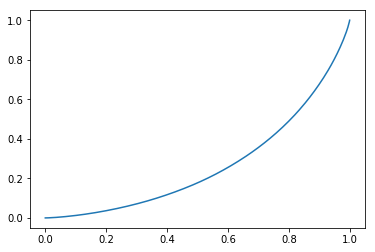

In [5]:
# Call the function with test values and parameter estimates for (CorrAct, CorrPcvd, DiscFac_center, DiscFac_spread)
AggWealthRatio, Lorenz, Gini, Avg_MPC = runRoszypalSchlaffmanExperiment(0.97, 0.9831, 0.986609223266, 0.00853886395698)

print('The aggregate wealth to income ratio is ' + str(AggWealthRatio))
#print('The Lorenz curve for assests is ' + str(Lorenz))
print('The Gini Coefficient for assests is ' + str(Gini))
print('The average MPC by income quantile is ' + str(Avg_MPC))
